# Project task 01: Hidden Markov Model

## 0. tl;dr

Complete the functions 
* `HMM_TxtGenerator.forwards` (2pt)
* `HMM_TxtGenerator.log_likelihood` (2pt)
* `HMM_TxtGenerator.backwards` (2pt)
* `HMM_TxtGenerator.generate_sentence` (2pt)

in `generator.py`

and
* `classify_review` (2pt)

in `classification.py`.

Then push `generator.py` and `classification.py` to the remote Artemis repository.

Only functionality in the python files will be graded. Carefully read the method docstrings to understand the task, parameters and what output is expected.  
Please make sure that you do not modify any of the other functions or class attributes, since it may interfere with the automatic grading.

If you would like some additional context for what we are implementing, you can go through the notebook below.

In [1]:
import numpy as np
import scipy.sparse as sp
import re
import json
import time
import math
from scipy.sparse import linalg as spl
from collections import defaultdict
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from IPython.display import Image

from generator import HMM_Params, HMM_TxtGenerator
from classification import classify_review

%matplotlib inline

## 1. Introduction


In this project task, we use hidden markov models (HMMs) as a probabilistic generative model for text data. Intuitively, we can think of each latent variable $Z_t \in \lbrace 1,...,K \rbrace$ as, e.g., a hidden part-of-speech tag (like noun, verb, or adjective). Each observation $X_t\in \lbrace 1,...,V \rbrace$ is a word. $K$ denotes number of possible states and $V$ denotes the number of words in our vocabulary. The model generates a sequence of words (i.e. a sentence) as follows:
* Generate $Z_1$ from the initial probability distribution ${\pi} \in \mathbb{R}^K$:
\begin{equation}
Pr(Z_1=k) = \mathbf{\pi}_k.
\end{equation}
* Given $Z_1$, generate $Z_2,Z_3,...,Z_t$ as :
\begin{equation}
Pr(Z_{t+1}=j|Z_t=i) = \mathbf{A}_{ij},
\end{equation}
where $\mathbf{A} \in \mathbb{R}^{K\times K}$ is the state transition probability matrix.

* Given $Z_t$, generate $X_t$ as :
\begin{equation}
Pr(X_{t}=v|Z_t=i) = \mathbf{B}_{iv},
\end{equation}

In this task, we will use HMMs to classify restaurant reviews as either 1-star or 5-star. We will do so via the following procedure:
* We select a subset of 1-star (resp. 5-star) reviews as a training set. (will be stored in variables `reviews_1star_train` (resp. `reviews_5star_train`))  
* We learn **two** HMMs: HMM $\mathcal{H}_1$ on `reviews_1star_train` and HMM $\mathcal{H}_5$ on `reviews_5star_train`.
* In the test phase, we classify a sentence based on the likelihood of the sentence in $\mathcal{H}_1$ and $\mathcal{H}_5$ and the class probability of 1-star and 5-star reviews.

## 2. Load data

We'll be working with a subset of reviews for restaurants in Las Vegas. The reviews that we'll be working with are either 1-star or 5-star. 

In [2]:
data = np.load("task_01_data.npy", allow_pickle=True)
reviews_1star = data.item()["reviews_1star"]
reviews_5star = data.item()["reviews_5star"]

The variable `reviews_1star` (resp. `reviews_5star`) is a list of sentences of 1-star (resp. 5-star) reviews. Each sentence is itself a list of words.

We can inspect what the sentences look like:

In [3]:
print("a 1-star review: " + str(reviews_1star[1]))
print("a 5-star review: " + str(reviews_5star[1]))

a 1-star review: ['This', 'place', 'tops', 'the', 'least', 'favorite', 'list', 'by', 'a', 'long', 'shot']
a 5-star review: ['Filet', 'mignon', 'and', 'lobster', 'tail', 'was', 'very', 'good']


## 3. Training

Each sentence is assumed to be generated from an HMM $\mathcal{H}$ as explained in introduction.
We denote the parameters of $\mathcal{H}$ by $ \mathbf{A},\mathbf{B},\pi$.  
We store the model parameters using the `HMM_Params` class in `generator.py`. It contains three randomly-initialized stochastic matrices $\mathbf{A}\in \mathbb{R}^{K\times K}$, $\mathbf{B}\in \mathbb{R}^{K\times V}$, and $\pi \in \mathbb{R}^{K\times 1}$.
You do not need to change anything in this class.


The Hidden Markov Model is implemented in the class `HMM_TxtGenerator` in `generator.py`.  
**Before proceeding, implement the following functions**, which will be used by the EM algorithm:
* `HMM_TxtGenerator.forwards` (2pt)
* `HMM_TxtGenerator.log_likelihood` (2pt)
* `HMM_TxtGenerator.backwards` (2pt)

For parameter descriptions, please refer to the docstrings. 

Note that `HMM_TxtGenerator` is a model which will be defined only on one corpus. We are going to make two instances of this class, one for 1-star reviews and one for 5-star reviews.  
To train our model, we split each set of reviews (i.e. `reviews_1star` and `reviews_5star`) into training/test sets.
You can change percentage of train/test instances by setting `train_percentage`.

In [4]:
train_percentage = 80
def split_to_traintest(in_list,percentage):
    n_train = math.floor(len(in_list)*percentage/100)
    n_test  = len(in_list) - n_train
    return in_list[0:n_train],in_list[n_train:]
reviews_1star_train , reviews_1star_test = split_to_traintest(reviews_1star,train_percentage)
reviews_5star_train , reviews_5star_test = split_to_traintest(reviews_5star,train_percentage)
reviews_test = reviews_1star_test + reviews_5star_test
y_test  = [1 for i in range(len(reviews_1star_test))] + \
          [5 for i in range(len(reviews_5star_test))]

We now define two HMMs. `K` is the number of possible hidden states.

In [5]:
K = 8
hmm_1 = HMM_TxtGenerator(reviews_1star_train,K)
hmm_5 = HMM_TxtGenerator(reviews_5star_train,K)

Now we fit the HMMs to their corresponding training sets using expectation–maximization (EM) algorithm.

The function `HMM_TxtGenerator.learn_params(num_iter)` repeats EM steps for some iterations, and returns the history of log-likelihood during the steps.
At the following, we repeat EM updates for `n_iter` iterations and plot the history of log-likelihood. When log-probability of evidence stops increasing, it means that we can quit EM updates. Please note that log-likelihood might increase dramatically in first iterations. Therefore, in the plot the amount of increase in final iterations would look small. 

You can increase/decrease the number of iterations by setting `n_iter`.

In [1]:
import numpy as np
import scipy.sparse as sp
import re
import json
import time
import math
from scipy.sparse import linalg as spl
from collections import defaultdict
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from IPython.display import Image

from generator import HMM_Params, HMM_TxtGenerator
from classification import classify_review

%matplotlib inline

data = np.load("task_01_data.npy", allow_pickle=True)
reviews_1star = data.item()["reviews_1star"]
reviews_5star = data.item()["reviews_5star"]

print("a 1-star review: " + str(reviews_1star[1]))
print("a 5-star review: " + str(reviews_5star[1]))

train_percentage = 80
def split_to_traintest(in_list,percentage):
    n_train = math.floor(len(in_list)*percentage/100)
    n_test  = len(in_list) - n_train
    return in_list[0:n_train],in_list[n_train:]
reviews_1star_train , reviews_1star_test = split_to_traintest(reviews_1star,train_percentage)
reviews_5star_train , reviews_5star_test = split_to_traintest(reviews_5star,train_percentage)
reviews_test = reviews_1star_test + reviews_5star_test
y_test  = [1 for i in range(len(reviews_1star_test))] + \
          [5 for i in range(len(reviews_5star_test))]

K = 8
hmm_1 = HMM_TxtGenerator(reviews_1star_train,K)
hmm_5 = HMM_TxtGenerator(reviews_5star_train,K)

%matplotlib inline
%load_ext autoreload
%autoreload 2

a 1-star review: ['This', 'place', 'tops', 'the', 'least', 'favorite', 'list', 'by', 'a', 'long', 'shot']
a 5-star review: ['Filet', 'mignon', 'and', 'lobster', 'tail', 'was', 'very', 'good']


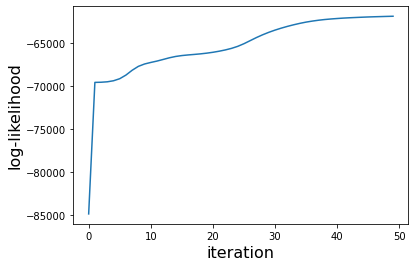

In [2]:
n_iter = 50
history_loglik_1 = hmm_1.learn_params(n_iter)
plt.figure()
plt.plot(range(len(history_loglik_1)) , history_loglik_1)
plt.xlabel("iteration",fontsize=16)
plt.ylabel("log-likelihood",fontsize=16)
plt.show()

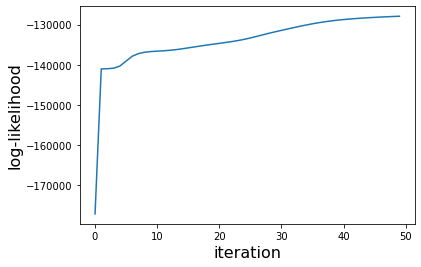

In [4]:
history_loglik_5 = hmm_5.learn_params(n_iter)
plt.figure()
plt.plot(range(len(history_loglik_5)) , history_loglik_5)
plt.xlabel("iteration",fontsize=16)
plt.ylabel("log-likelihood",fontsize=16)
plt.show()

## 4. Data generation
The trained models can be used to generate new 1- and 5-star reviews of a specified length.  
**Before proceeding, implement** the generative process described in "1. Introduction" in the function `HMM_TxtGenerator.generate_sentence` in `generator.py` (2pt). 

In [3]:
sample_1star = hmm_1.generate_sentence(15)
sample_5star = hmm_5.generate_sentence(15)
print("generated 1star review: ")
print(sample_1star)
print("\n")
print("generated 5star review: ")
print(sample_5star)


generated 1star review: 
['Hostess', 'ok', 'place', 'really', 'off', 'send', 'onto', 'like', 'require', 'them', 'was', 'got', 'better', 'percent', 'the']


generated 5star review: 
['am', 'appetizer', 'antibotics', 'Portland', 'tables', 'conclusion', 'Tea', 'torta', 'OpenTable', 'shack', 'butter', "we've", 'rooms', 'gentlemans', 'deserves']


## 5. Classification

Now assume that we have a sentence of length $T$ and we want to classify it as either 1-star or 5-star. For this task, we consider the following probabilistic model:

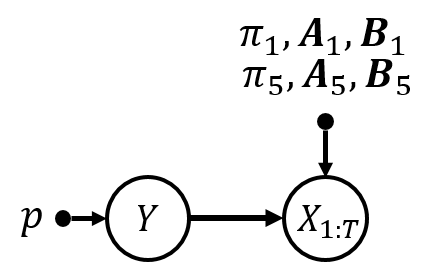

In [6]:
Image(filename ="task_01_classification.png" , width=250)

In the above model, $Y\in \lbrace 1,5 \rbrace$ indicates the class of the review, either 1-star or 5-star. 

The generative process of the above model is as follows:
* Generate the class of the sentence:
\begin{equation}
Pr(Y=1) = p \;\;\;\;, \;\;\;\; Pr(Y=5) = 1-p \;\;.
\end{equation}
* If 1-star (resp. 5-star) category is chosen, generate the sentence from marginal distribution of HMM 1 (resp. 5):
\begin{equation}
Pr(X_{1:T} | Y) = 
\begin{cases}
Pr(X_{1:T}|\pi_1,\mathbf{A}_1,\mathbf{B}_1) \;\;\;\;\;\; Y=1 \\
Pr(X_{1:T}|\pi_5,\mathbf{A}_5,\mathbf{B}_5) \;\;\;\;\;\; Y=5
\end{cases}
\end{equation}

To classify a sentence $X_{1:T}$, we can simply compare $Pr(Y=1|X_{1:T})$ with $Pr(Y=5|X_{1:T})$.

Due to Bayes' theorem, this is equivalent to comparing
$logPr(Y=1)+logPr(X_{1:T}|\pi_1,\mathbf{A}_1,\mathbf{B}_1)$ and $logPr(Y=5)+ logPr(X_{1:T}|\pi_5,\mathbf{A}_5,\mathbf{B}_5)$. More precisely:
* The terms $logPr(X_{1:T}|\pi_1,\mathbf{A}_1,\mathbf{B}_1)$ and $logPr(X_{1:T}|\pi_5,\mathbf{A}_5,\mathbf{B}_5)$ are provided by the functions `hmm_1.loglik_sentence` and `hmm_5.loglik_sentence`. 
* We can approximate $Pr(Y=1)$ and $Pr(Y=5)$ simply by computing the frequency of each class in the training set.

**Before proceeding, implement** this classification procedure in the function `classify_review` in `classification.py`.

We assume that if a sentence contains a word which is **not** in the vocabulary of a model, the likelihood of the sentence is zero and log-likelihood is $-\infty$.  
In the the following, we drop the samples in test set which have $-\infty$ log-likelihood in both models. We store all other samples in `reviews_test_filtered` and their categories in `y_test_filtered`. 

In [7]:
temp_reviews = []
temp_y = []
for counter in range(len(reviews_test)):
    current_review = reviews_test[counter]
    current_y   = y_test[counter]
    if(hmm_1.is_in_vocab(current_review) | hmm_5.is_in_vocab(current_review)):
        temp_reviews.append(current_review)
        temp_y.append(current_y)
reviews_test_filtered = temp_reviews
y_test_filtered = temp_y

Finally, we evaluate our classifier on the test set.

In [8]:
p = len(reviews_1star_train)/(len(reviews_1star_train)+len(reviews_5star_train))
y_pred = []
for sent in reviews_test_filtered:
    y_pred.append(classify_review(hmm_1,hmm_5,p,sent))
accuracy = np.sum(np.array(y_pred)==np.array(y_test_filtered))/len(y_test_filtered)
print("classification accuracy for " + str(len(y_test_filtered)) +\
      " test instances: " + str(accuracy))

classification accuracy for 206 test instances: 0.7330097087378641
